In [1]:
import pandas as pd
import numpy as np
from snorkel.labeling import labeling_function
from snorkel.labeling import LabelingFunction

In [2]:
data=pd.read_csv("creditcard.csv")

In [3]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## We can observe that the frauds have a different distribution than normal transactions

array([[<AxesSubplot:title={'center':'V1'}>]], dtype=object)

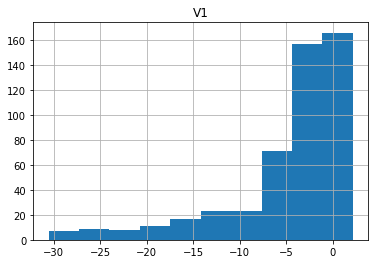

In [4]:
data[data["Class"]==1].hist("V1")

array([[<AxesSubplot:title={'center':'V1'}>]], dtype=object)

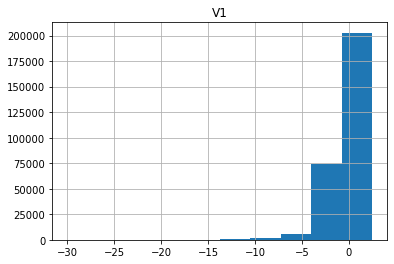

In [5]:
data[data["V1"]>-30].hist("V1")

array([[<AxesSubplot:title={'center':'V2'}>]], dtype=object)

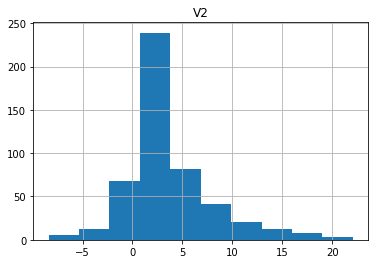

In [6]:
data[data["Class"]==1].hist("V2")

array([[<AxesSubplot:title={'center':'V2'}>]], dtype=object)

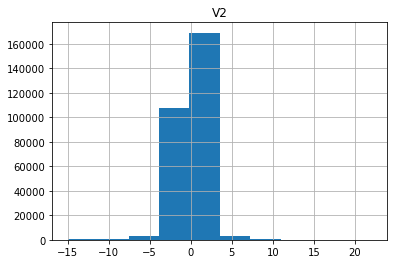

In [7]:
data[data["V2"]>-15].hist("V2")

# Labeling functions

Labeling functions are used in a method called weak learning. Snorkel is a startup that keeps a python package that has many functions used for this type of machine learning operations. The motivation is to use multiple decision making ideas that are not 100% effective but that are based on expert judgement on the topic covered. In their website their offer a compelling exercise on using it for spam detection.

In this example we will show that even without specific expert knowledge with good heuristics for our rules, frauds are outliers in our dataset, we can get a good result for classification using unsupervised learning and weak learning.

In [3]:
def mult_dim_outlier(x, values, cols, minmaxs):
    """
    Simple function that looks at a row of our data and decides if it is an outlier based on if it is higher (or lower, decided by minmax) than a set of thresholds.
    """
    for value, col, minmax in zip(values, cols, minmaxs):
        if minmax=="min":
            if x[col]>value:
                return -1
        if minmax=="max":
            if x[col]<value:
                return -1
    return 1

In [4]:
def mult_dim_normal(x, values, cols):
    """
    Simple function that looks at a row of our data and decides if it is a regular data point by seeing it is in between two thresholds.
    """
    for value, col, in zip(values, cols):
        if x[col]<value[0]:
            return -1
        if x[col]>value[1]:
            return -1
    return 0

Creating the labeling functions based on the logic of our helper functions above.

In [5]:
def make_out_col_lf(values, cols, minmaxs):
    return LabelingFunction(
        name=f"out_col_{cols}_{minmaxs}",
        f=mult_dim_outlier,
        resources=dict(values=values, cols=cols, minmaxs=minmaxs),
    )

In [6]:
def make_nor_col_lf(values, cols):
    return LabelingFunction(
        name=f"nor_col_{cols}",
        f=mult_dim_normal,
        resources=dict(values=values, cols=cols),
    )

# First Experiment

We setup an experiment by using all of our columns and a randomly generated sample of labeling functions that decides for outliers or regular data points. 

In [12]:
import random

lfs=[]
names=[]
for i in range(100):
    n=random.randint(1,2)
    cols= random.sample(list(data.drop(["Time", "Class"], axis=1).columns), n)
    minmaxs=random.choices(["min", "max"], k=n)
    values=[]
    for j in range(len(cols)):
        if minmaxs[j]=="max":
            values.append(np.percentile(data[cols[j]], 99))
        if minmaxs[j]=="min":
            values.append(np.percentile(data[cols[j]], 1))
    new_lf=make_out_col_lf(values, cols, minmaxs)
    name=new_lf.name
    if name not in names:
        names.append(name)
        lfs.append(new_lf)
for i in range(100):
    n=random.randint(3,5)
    cols= random.sample(list(data.drop(["Time", "Class"], axis=1).columns), n)
    values=[]
    for j in range(len(cols)):
        values.append([np.percentile(data[cols[j]], 5), np.percentile(data[cols[j]], 95)])
    new_lf=make_nor_col_lf(values, cols)
    name=new_lf.name
    if name not in names:
        names.append(name)
        lfs.append(new_lf)

In [13]:
fraud=data[data["Class"]==1]
non_fraud=data[data["Class"]==0]
for i in range(5):
    fraud=pd.concat([fraud, fraud])
non_fraud=non_fraud.reindex(np.random.permutation(non_fraud.index))
non_fraud=non_fraud[0:15744]
balanced_data=pd.concat([non_fraud, fraud])

In [14]:
from snorkel.labeling import PandasLFApplier

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=balanced_data)
L_test = applier.apply(df=data)

100%|██████████| 284807/284807 [10:16<00:00, 462.15it/s]


In [15]:
from snorkel.labeling import LFAnalysis
LFAnalysis(L=L_test, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
"out_col_['V5', 'V15']_['max', 'min']",0,[1],0.000091,0.000091,0.000091
"out_col_['V12', 'V10']_['min', 'min']",1,[1],0.001503,0.001503,0.001239
"out_col_['V9', 'V21']_['min', 'max']",2,[1],0.000260,0.000260,0.000204
"out_col_['V6', 'V5']_['min', 'max']",3,[1],0.004287,0.004287,0.004154
out_col_['V25']_['max'],4,[1],0.010003,0.010003,0.009610
...,...,...,...,...,...
"nor_col_['V17', 'Amount', 'V21', 'V3', 'V24']",182,[0],0.623872,0.623872,0.066171
"nor_col_['V25', 'V22', 'V20', 'V11', 'V15']",183,[0],0.621347,0.621347,0.074026
"nor_col_['V24', 'V8', 'V16', 'Amount', 'V7']",184,[0],0.636076,0.636076,0.072895
"nor_col_['V3', 'V20', 'V4', 'V14']",185,[0],0.689411,0.689411,0.078120


In [17]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_test, n_epochs=10, log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████| 10/10 [00:00<00:00, 434.79epoch/s]
INFO:root:Finished Training


In [18]:
label_model_acc = label_model.score(L=L_test, Y=data["Class"], tie_break_policy="random")["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Label Model Accuracy:     95.1%


In [19]:
label_model.score(L=L_test, Y=data["Class"], metrics=["f1", "accuracy", "precision"])

{'f1': 0.057166024731400776,
 'accuracy': 0.9510089288535746,
 'precision': 0.029565946739358355}

We can see that the performance of our weak model is not great with a precision of only .7%. We focus on precision as this gives us the rate of true positives compared to false positives. In something like fraud detection where we want to cover as many fraud scenarios with limited resources and without creating a burden on customers whose false positives will impact having a high precision rate will allow us to make an efficient use of resources.

In [20]:
data["weak_class"]=label_model.predict(L=L_test)
balanced_data["weak_class"]=label_model.predict(L=L_train)

In [21]:
data[data["weak_class"]==1]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,weak_class
18,14.0,-5.401258,-5.450148,1.186305,1.736239,3.049106,-1.763406,-1.559738,0.160842,1.233090,...,0.984460,2.458589,0.042119,-0.481631,-0.621272,0.392053,0.949594,46.80,0,1
51,36.0,-1.004929,-0.985978,-0.038039,3.710061,-6.631951,5.122103,4.371691,-2.006868,-0.278736,...,-0.381671,0.969719,0.019445,0.570923,0.333278,0.857373,-0.075538,1402.95,0,1
82,52.0,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,1.46,0,1
83,53.0,-1.198968,-1.474100,1.840326,-4.515824,0.327567,-0.174469,0.959726,-1.026456,1.700435,...,0.334614,-0.364541,-0.310186,-0.302599,-1.243924,-1.123457,-0.734351,89.17,0,1
85,55.0,-4.575093,-4.429184,3.402585,0.903915,3.002224,-0.491078,-2.705393,0.666451,1.922216,...,0.853360,-0.971600,-0.114862,0.408300,-0.304576,0.547785,-0.456297,200.01,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284733,172726.0,-1.353026,0.289945,0.173684,-3.780442,-1.173016,-0.159307,3.009433,-1.544902,1.422788,...,-0.701799,-0.144663,1.056709,1.074381,-1.129447,0.033781,-0.325899,405.09,0,1
284742,172734.0,-1.248847,2.279478,-1.144824,-0.263061,0.070912,-0.323414,-1.454139,-5.069379,-0.827733,...,0.261945,0.490272,-0.112758,-0.453183,-0.694933,-0.106693,0.082714,9.99,0,1
284772,172760.0,-6.713826,2.369104,-3.534768,-0.368259,-1.721030,-1.322808,-0.190876,0.891149,2.068476,...,0.994246,-0.002140,-0.072979,-0.167159,-0.387271,-2.616341,0.474584,19.59,0,1
284795,172778.0,-12.516732,10.187818,-8.476671,-2.510473,-4.586669,-1.394465,-3.632516,5.498583,4.893089,...,-1.565026,0.890675,-1.253276,1.786717,0.320763,2.090712,1.232864,9.87,0,1


## We could use the fact we have annotated data to have better performance

First we analyze some correlations so we do some feature selection so only variables with high correlation to fraud are considered in our simple model. As we saw before for V2 fraud scenarios were not closer to the edges but actually closer to the center.

The reasoning of this simple analysis is to show that we can use expert knowledge to know what to look at instead of detailed analysis based on statistics using knowledge of the correct labels.

In [22]:
data.corr()["Class"].sort_values()

V17          -0.326481
V14          -0.302544
V12          -0.260593
V10          -0.216883
V16          -0.196539
V3           -0.192961
V7           -0.187257
V18          -0.111485
V1           -0.101347
V9           -0.097733
V5           -0.094974
V6           -0.043643
Time         -0.012323
V24          -0.007221
V13          -0.004570
V15          -0.004223
V23          -0.002685
V22           0.000805
V25           0.003308
V26           0.004455
Amount        0.005632
V28           0.009536
V27           0.017580
V8            0.019875
V20           0.020090
V19           0.034783
V21           0.040413
V2            0.091289
V4            0.133447
weak_class    0.154172
V11           0.154876
Class         1.000000
Name: Class, dtype: float64

In [23]:
corr_columns=["V17", "V14", "V12", "V10", "V16", "V3", "V7", "V4", "V11"]

In [24]:
import random

lfs2=[]
names=[]
for i in range(100):
    n=random.randint(1,2)
    cols= random.sample(corr_columns, n)
    minmaxs=random.choices(["min", "max"], k=n)
    values=[]
    for j in range(len(cols)):
        if minmaxs[j]=="max":
            values.append(np.percentile(data[cols[j]], 99.5)) #99 was good in almost all frauds detected, 99.9 was good in that it lowered false positives but lowered fraud detection too much
        if minmaxs[j]=="min":
            values.append(np.percentile(data[cols[j]], 0.5))
    new_lf=make_out_col_lf(values, cols, minmaxs)
    name=new_lf.name
    if name not in names:
        names.append(name)
        lfs2.append(new_lf)
for i in range(100):
    n=random.randint(3,5)
    cols= random.sample(corr_columns, n)
    values=[]
    values.append([np.percentile(data[cols[j]], 5), np.percentile(data[cols[j]], 95)])
    new_lf=make_nor_col_lf(values, cols)
    name=new_lf.name
    if name not in names:
        names.append(name)
        lfs2.append(new_lf)

In [25]:
from snorkel.labeling import PandasLFApplier

applier2 = PandasLFApplier(lfs=lfs2)
#L_train2 = applier2.apply(df=balanced_data)
L_test2 = applier2.apply(df=data)

100%|██████████| 284807/284807 [04:02<00:00, 1174.38it/s]


In [26]:
from snorkel.labeling import LFAnalysis
LFAnalysis(L=L_test2, lfs=lfs2).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
out_col_['V16']_['min'],0,[1],0.005003,0.005003,0.004108
"out_col_['V16', 'V14']_['max', 'max']",1,[1],0.000586,0.000586,0.000565
"out_col_['V11', 'V3']_['min', 'min']",2,[1],0.000509,0.000509,0.000502
out_col_['V3']_['max'],3,[1],0.005003,0.005003,0.005003
out_col_['V12']_['min'],4,[1],0.005003,0.005003,0.004031
...,...,...,...,...,...
"nor_col_['V12', 'V16', 'V10']",155,[0],0.899995,0.899995,0.036937
"nor_col_['V12', 'V4', 'V11']",156,[0],0.899995,0.899995,0.036937
"nor_col_['V10', 'V11', 'V12', 'V14', 'V16']",157,[0],0.899995,0.899995,0.033560
"nor_col_['V17', 'V16', 'V7', 'V14', 'V4']",158,[0],0.899995,0.899995,0.034676


In [27]:
from snorkel.labeling.model import LabelModel

label_model2 = LabelModel(cardinality=2, verbose=True)
label_model2.fit(L_train=L_test2, n_epochs=10 , log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████| 10/10 [00:00<00:00, 434.78epoch/s]
INFO:root:Finished Training


In [28]:
label_model2.score(L=L_test2, Y=data["Class"], metrics=["f1", "accuracy", "precision"])

{'f1': 0.6427688504326328,
 'accuracy': 0.9989852777494935,
 'precision': 0.8201892744479495}

In [29]:
data["weak_class2"]=label_model2.predict(L=L_test2)
#balanced_data["weak_class2"]=label_model2.predict(L=L_train2)

In [30]:
(data["weak_class2"]==data["Class"]).sum()

284518

In [31]:
len(data[data["weak_class2"]==1])

317

In [33]:
(data["weak_class2"]==data["Class"]).sum()/len(data["weak_class2"])

0.9989852777494935

In [34]:
frauds=data[data["Class"]==1]
(frauds["weak_class2"]==frauds["Class"]).sum()/len(data[data["weak_class2"]==1]["weak_class2"])

0.8201892744479495

In [35]:
(frauds["weak_class2"]==frauds["Class"]).sum()

260

In [36]:
frauds

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,weak_class,weak_class2
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1,1,0
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1,0,0
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1,1,0
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1,1,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1,1,0
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1,1,0
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1,1,0
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1,1,1


In [37]:
import pickle

i=3
with open("models/lf_applier_label_model"+str(i)+".pickle", "wb") as f:
    pickle.dump((lfs2, applier2, label_model2), f)

# Test predictions

Now that we used all the data we can to see the effectiveness of our weak learning predictions. However that model does not allow us to make predictions, instead let us make a training and test set where we use weak labels to train and then predict in a test.

We will make a 80-20 split based on time so we can train on past transactions and then make future predictions.

In [38]:
train_data=data[data["Time"]<=138233]
test_data=data[data["Time"]>138233]

In [39]:
lfs3=[]
names=[]
for i in range(100):
    n=random.randint(1,2)
    cols= random.sample(corr_columns, n)
    minmaxs=random.choices(["min", "max"], k=n)
    values=[]
    for j in range(len(cols)):
        if minmaxs[j]=="max":
            values.append(np.percentile(train_data[cols[j]], 99.5)) #99 was good in almost all frauds detected, 99.9 was good in that it lowered false positives but lowered fraud detection too much
        if minmaxs[j]=="min":
            values.append(np.percentile(train_data[cols[j]], 0.5))
    new_lf=make_out_col_lf(values, cols, minmaxs)
    name=new_lf.name
    if name not in names:
        names.append(name)
        lfs3.append(new_lf)
for i in range(100):
    n=random.randint(3,5)
    cols= random.sample(corr_columns, n)
    values=[]
    values.append([np.percentile(train_data[cols[j]], 5), np.percentile(train_data[cols[j]], 95)])
    new_lf=make_nor_col_lf(values, cols)
    name=new_lf.name
    if name not in names:
        names.append(name)
        lfs3.append(new_lf)

In [40]:
from snorkel.labeling import PandasLFApplier

applier3 = PandasLFApplier(lfs=lfs3)
L_test3 = applier3.apply(df=train_data)

100%|██████████| 211041/211041 [03:00<00:00, 1166.63it/s]


In [41]:
from snorkel.labeling import LFAnalysis
LFAnalysis(L=L_test3, lfs=lfs3).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
out_col_['V16']_['min'],0,[1],0.005004,0.005004,0.003890
"out_col_['V16', 'V14']_['max', 'max']",1,[1],0.000630,0.000630,0.000597
"out_col_['V11', 'V3']_['min', 'min']",2,[1],0.000521,0.000521,0.000507
out_col_['V3']_['max'],3,[1],0.005004,0.005004,0.005004
out_col_['V12']_['min'],4,[1],0.005004,0.005004,0.003824
...,...,...,...,...,...
"nor_col_['V12', 'V16', 'V10']",155,[0],0.900000,0.900000,0.036817
"nor_col_['V12', 'V4', 'V11']",156,[0],0.900000,0.900000,0.036817
"nor_col_['V10', 'V11', 'V12', 'V14', 'V16']",157,[0],0.900000,0.900000,0.032856
"nor_col_['V17', 'V16', 'V7', 'V14', 'V4']",158,[0],0.900000,0.900000,0.033690


In [42]:
from snorkel.labeling.model import LabelModel

label_model3 = LabelModel(cardinality=2, verbose=True)
label_model3.fit(L_train=L_test3, n_epochs=10 , log_freq=100, seed=123)

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████| 10/10 [00:00<00:00, 526.32epoch/s]
INFO:root:Finished Training


In [43]:
label_model3.score(L=L_test3, Y=train_data["Class"], metrics=["f1", "accuracy", "precision"])

{'f1': 0.6636904761904762,
 'accuracy': 0.9989291180386749,
 'precision': 0.802158273381295}

In [44]:
train_data["weak_class3"]=label_model3.predict(L=L_test3)

C:\Users\xnive\anaconda3\envs\spam\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(random_state=123)
model.fit(train_data.drop(["Time","Class", "weak_class", "weak_class2", "weak_class3"], axis=1), train_data["weak_class3"])

RandomForestClassifier(random_state=123)

In [47]:
test_data["pred3"]=model.predict(test_data.drop(["Time","Class", "weak_class", "weak_class2"], axis=1))

C:\Users\xnive\anaconda3\envs\spam\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
len(test_data[test_data["pred3"]==1])

36

In [49]:
len(test_data[test_data["Class"]==1])

98

In [50]:
(test_data["pred3"]==test_data["Class"]).sum()

73696

In [51]:
acc=(test_data["pred3"]==test_data["Class"]).sum()/len(test_data["Class"])
pre=len(test_data[(test_data["Class"]==1)&(test_data["pred3"]==1)])/len(test_data[test_data["pred3"]==1])
print("accuracy: ", acc, "\nprecision: ", pre)

accuracy:  0.9990510533308028 
precision:  0.8888888888888888


In [52]:
test_data[test_data["pred3"]==1]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V24,V25,V26,V27,V28,Amount,Class,weak_class,weak_class2,pred3
212516,138894.0,-1.298443,1.948100,-4.509947,1.305805,-0.019486,-0.509238,-2.643398,1.283545,-2.515356,...,-0.325948,0.290703,0.841295,0.643094,0.201156,0.01,1,1,0,1
214662,139767.0,0.467992,1.100118,-5.607145,2.204714,-0.578539,-0.174200,-3.454201,1.102823,-1.065016,...,-1.929717,0.319869,0.170636,0.851798,0.372098,120.54,1,1,1,1
220090,142019.0,-37.558067,-29.335992,-24.962322,8.413616,-35.182120,21.550496,36.877368,-8.915982,5.046566,...,1.272716,1.965365,0.767817,3.248189,13.013546,5964.95,0,1,0,1
220212,142071.0,-46.855047,-45.607973,-18.320903,13.129143,0.775717,-2.695834,1.087461,-4.241002,6.645063,...,2.023816,-3.856097,-0.478302,-4.139269,13.999688,303.80,0,1,0,1
223572,143434.0,-2.729482,3.312495,-4.242710,5.036985,-0.376561,-1.532462,-3.449159,1.856839,-3.623334,...,-0.462309,0.510683,0.046665,0.514646,0.140999,1.00,1,1,1,1
223618,143456.0,-2.006582,3.676577,-5.463811,7.232058,-1.627859,-0.996755,-4.299833,2.268867,-3.651067,...,-0.449864,0.023702,0.536905,0.485864,-0.042393,1.00,1,1,1,1
224569,143863.0,-41.928738,-40.803981,-22.588759,11.844703,-8.729597,3.281296,14.203189,-5.245286,4.874533,...,1.321750,-4.084350,-0.601799,-2.787339,-0.816680,200.00,0,1,0,1
226814,144808.0,-2.405207,2.943823,-7.616654,3.533374,-5.417494,-0.112632,-1.329372,1.709417,-2.322716,...,-0.260616,0.405316,0.029107,0.519807,-0.469537,667.55,1,1,1,1
226877,144839.0,-6.423306,1.658515,-5.866440,2.052064,-0.615817,-3.372266,-5.036556,2.643106,-2.274630,...,-0.158278,1.198797,-0.261258,0.780125,-0.731801,0.00,1,1,1,1
230476,146344.0,-0.099724,2.795414,-6.423856,3.247513,-1.632290,-2.766665,-2.312223,0.961014,-1.896001,...,0.008495,-0.174501,0.575295,0.152876,-0.098173,94.82,1,1,1,1


In [53]:
import pickle

i=1
with open("models/train_test_lf_applier_label_model_data"+str(i)+".pickle", "wb") as f:
    pickle.dump((lfs3, applier3, label_model3, model, train_data, test_data), f)

In [8]:
import pickle

i=1
with open("models/train_test_lf_applier_label_model_data"+str(i)+".pickle", "rb") as f:
    lfs3, applier3, label_model3, model, train_data, test_data=pickle.load(f)

Let us compare the performance with training using the right labels.

In [55]:
model=RandomForestClassifier(random_state=123)
model.fit(train_data.drop(["Time","Class", "weak_class", "weak_class2", "weak_class3"], axis=1), train_data["Class"])

RandomForestClassifier(random_state=123)

In [56]:
test_data["pred4"]=model.predict(test_data.drop(["Time","Class", "weak_class", "weak_class2", "pred3"], axis=1))

In [61]:
len(test_data[test_data["pred4"]==1])

69

In [62]:
len(test_data[test_data["Class"]==1])

98

In [63]:
(test_data["pred4"]==test_data["Class"]).sum()

73735

In [64]:
acc=(test_data["pred4"]==test_data["Class"]).sum()/len(test_data["Class"])
pre=len(test_data[(test_data["Class"]==1)&(test_data["pred4"]==1)])/len(test_data[test_data["pred4"]==1])
print("accuracy: ", acc, "\nprecision: ", pre)

accuracy:  0.9995797521893556 
precision:  0.9855072463768116


# We can also use ranking algorithms to prioritize getting most suspicious transactions instead of classifying fraud.

In [9]:
import xgboost as xgb

lmart = xgb.sklearn.XGBRanker(objective='rank:ndcg',
      learning_rate=0.1,
      gamma=1.0,
      min_child_weight=0.1,
      max_depth=6,
      random_state=42)

In [19]:
train_data["ID"]=np.ceil((train_data["Time"]+1)/100)

In [20]:
train_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,weak_class,weak_class2,weak_class3,ID
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0,0,1.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.167170,0.125895,-0.008983,0.014724,2.69,0,0,0,0,1.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,0,0,1.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0,0,1.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211036,138228.0,1.827092,-0.246557,-0.242271,1.369299,-0.526296,-0.428085,-0.316310,-0.128321,0.709725,...,-0.085612,-0.569535,0.056239,-0.016529,70.00,0,0,0,0,1383.0
211037,138229.0,1.634078,-2.030284,-0.390343,-0.294176,-1.720703,0.479898,-1.647632,0.317797,1.322113,...,-0.383474,-0.064507,0.035202,0.038100,249.89,0,0,0,0,1383.0
211038,138229.0,-0.676290,0.790262,0.412706,0.893393,1.436467,-0.436724,1.032846,-0.129557,-1.056698,...,1.240948,-0.186984,-0.205691,-0.023588,1.00,0,0,0,0,1383.0
211039,138230.0,-2.163301,0.011495,-1.867834,-0.646856,2.570721,-1.381507,1.605161,-0.624913,0.023222,...,-0.026975,0.511515,0.128130,0.551990,5.39,0,0,0,0,1383.0


In [22]:
groups = train_data.groupby('ID').size().to_frame('size')['size'].to_numpy()

In [25]:
lmart.fit(train_data.drop(["Time","Class", "weak_class", "weak_class2", "weak_class3"], axis=1), train_data["Class"], group=groups)

[23:04:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
          gamma=1.0, gpu_id=-1, importance_type=None,
          interaction_constraints='', learning_rate=0.1, max_delta_step=0,
          max_depth=6, min_child_weight=0.1, missing=nan,
          monotone_constraints='()', n_estimators=100, n_jobs=16,
          num_parallel_tree=1, objective='rank:ndcg', predictor='auto',
          random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
          subsample=1, tree_method='exact', validate_parameters=1, verbose=2,
          verbosity=None)

In [34]:
test_data["rank"]=lmart.predict(test_data.drop(["Time","Class", "weak_class", "weak_class2", "pred3"], axis=1))

In [64]:
test_data["rank"].nlargest(n=50).index[0:50].values

array([213116, 221018, 222133, 223618, 226814, 226877, 230476, 235634,
       235644, 238222, 239499, 241445, 243393, 243547, 243749, 243848,
       244004, 244333, 249963, 250761, 251904, 261925, 262826, 263274,
       263877, 276864, 279863, 212644, 223366, 223572, 229712, 234574,
       243699, 247995, 249828, 251866, 252124, 262560, 281144, 249167,
       221041, 263324, 280143, 261473, 251477, 252774, 249607, 238366,
       230076, 258403], dtype=int64)

In [68]:
test_data.loc[test_data["rank"].nlargest(n=70).index.values]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,weak_class,weak_class2,pred3,rank
213116,139117.0,-3.975939,-1.244939,-3.707414,4.544772,4.050676,-3.407679,-5.063118,1.007042,-3.190158,...,0.410531,-0.123612,0.877424,0.667568,8.30,1,1,1,0,5.403365
221018,142394.0,-3.367770,0.099249,-6.148487,3.401955,0.458307,-1.571630,-1.358708,0.672409,-3.188001,...,1.219815,0.000251,1.036011,0.004367,320.01,1,1,1,0,5.403365
222133,142840.0,-3.613850,-0.922136,-4.749887,3.373001,-0.545207,-1.171301,-4.172315,1.517016,-1.775833,...,-1.345551,-0.788329,1.055442,0.099971,144.80,1,1,1,0,5.403365
223618,143456.0,-2.006582,3.676577,-5.463811,7.232058,-1.627859,-0.996755,-4.299833,2.268867,-3.651067,...,0.023702,0.536905,0.485864,-0.042393,1.00,1,1,1,1,5.403365
226814,144808.0,-2.405207,2.943823,-7.616654,3.533374,-5.417494,-0.112632,-1.329372,1.709417,-2.322716,...,0.405316,0.029107,0.519807,-0.469537,667.55,1,1,1,1,5.403365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268375,163181.0,-5.238808,0.623013,-5.784507,1.678889,-0.364432,-0.477295,-4.276132,-0.695173,-2.971644,...,0.893041,0.865758,0.854657,-0.964482,39.98,1,1,1,0,4.389631
214662,139767.0,0.467992,1.100118,-5.607145,2.204714,-0.578539,-0.174200,-3.454201,1.102823,-1.065016,...,0.319869,0.170636,0.851798,0.372098,120.54,1,1,1,1,4.258021
215132,139951.0,-2.921944,-0.228062,-5.877289,2.201884,-1.935440,0.631141,-1.245106,1.511348,-1.899987,...,0.509131,0.172643,0.726781,0.234514,723.21,1,1,0,0,4.258021
237426,149236.0,-1.370976,-0.025465,-2.774907,2.650530,4.511309,-3.289344,-0.118841,-0.014279,-0.932773,...,0.371331,-0.370951,0.011970,0.145895,1.00,1,1,0,0,4.252036


In [70]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

print(average_precision_score(test_data["Class"], test_data["rank"]))
print(roc_auc_score(test_data["Class"], test_data["rank"]))

0.78231226962443
0.9805612300303734


In [83]:
test_data["prob4"] =model.predict_proba(test_data.drop(["Time","Class", "weak_class", "weak_class2", "pred3", "rank"], axis=1))[:,1]

In [84]:
print(average_precision_score(test_data["Class"], test_data["prob4"]))
print(roc_auc_score(test_data["Class"], test_data["prob4"]))

0.5867479708897738
0.8617704167511604


We can see that even though the precision and recall of the random forest model is higher, the rankng algorithm performs much better in average precision and roc_auc_score which means that the confidence that the highest values of each score are right is a lot higher for this model. Using ranking algorithm can be really useul when the task can be to prioritize alerts as it is not always possible to review every alert, but if given a score and the top 10, 100 can be reviewed there is a higher confidence the ranking model would perform better.

# We can try an approach using weak learners with bagging.

We create ranking models using our LF functions above and we can then normalize these rankings so that we can average their scores and use this as our final model.